#  Маркетинговый анализ развлекательного приложения Procrastinate Pro+

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.
В нашем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

В ходе исследование были разобраны следующие вопросы:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Загрузка данных и их подготовка к анализу

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

Посмотрим на датасеты и информацию о типах данных по каждой из импортируемых csv-файлов и подготовим их к анализу. Начнем с  данных о визитах

#### Предобработка visits

In [3]:
display(visits.head(5))
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Для удобства и в соответствии с правилами хорошего тона поменяем название столбцов.  

In [4]:
visits.columns

Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

In [5]:
visits = visits.rename(columns={'User Id': 'user_id',
                                'Region': 'region',
                                'Device': 'device',
                                'Channel': 'channel',
                                'Session Start': 'session_start',
                                'Session End': 'session_end'}
                      )
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Столбцы user_id, region, device и channel соответствуют своему типу данных. В столбцах session_start и session_end содержатся даты. Приведем их к типу данных datetime.

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Проверим колонки на наличие пропущенных значений и дубликатов

In [7]:
columns_with_miss = visits.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', visits.duplicated().sum())

Колонок с пропущенным значением: 0
Количество явных дубликатов: 0


In [8]:
display(visits['region'].unique())
display(visits['device'].unique())
visits['channel'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Пропущенных значений и явных дубликатов не обнаружено. Среди уникальных значений столбцов region, device и channel неявных дубликатов так же нет.

Проверим данные о заказах

#### Предобработка orders

In [9]:
display(orders.head(5))
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Для удобства и в соответствии с правилами хорошего тона поменяем название столбцов.  

In [10]:
orders.columns

Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')

In [11]:
orders = orders.rename(columns={'User Id': 'user_id',
                                'Event Dt': 'event_dt',
                                'Revenue': 'revenue'}
                      )
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

В столбце event_dt содержатся даты. Приведем его к типу данных datetime.

In [12]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Проверим колонки на наличие пропущенных значений и дубликатов

In [13]:
columns_with_miss = orders.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', orders.duplicated().sum())

Колонок с пропущенным значением: 0
Количество явных дубликатов: 0


Пропущенных значений и явных дубликатов не обнаружено. 

Проверим последнюю таблицу, с данными о расходах

#### Предобработка costs

In [14]:
display(costs.head(5))
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Для удобства и в соответствии с правилами хорошего тона поменяем название столбца Channel.

In [15]:
costs = costs.rename(columns={'Channel': 'channel'})
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

В столбце dt содержатся даты. Приведем его к типу данных datetime.

In [16]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Проверим колонки на наличие пропущенных значений и дубликатов

In [17]:
columns_with_miss = costs.isna().sum()
columns_with_miss = columns_with_miss[columns_with_miss!=0]
print ('Колонок с пропущенным значением:', len(columns_with_miss))
columns_with_miss.sort_values(ascending=False)
print ('Количество явных дубликатов:', costs.duplicated().sum())

Колонок с пропущенным значением: 0
Количество явных дубликатов: 0


In [18]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Пропущенных значений и явных дубликатов не обнаружено. В колонке сhannel неявные дубликаты отсутствуют.  
Так же для готовых функций нам понадобиться переменная User. За основу берем датасет с визитами

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

В целях маркетингового анализа зададим функции, которые помогут нам с оценкой окупаемости рекламного бюджета по источникам, странам и каналам, а так же наглядно визуализируют полученные данные

**Функция для создания профилей пользователей:**

In [19]:
def get_profiles(sessions, orders, costs):
 
    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )
 
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
 
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 
 
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
 
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
 
    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
 
    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
 
    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
 
    return profiles
 

**Функция для подсчёта Retention Rate:**

In [20]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта конверсии:**

In [21]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**Функция для подсчёта LTV и ROI:**

In [22]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функция для сглаживания датафрейма:**

In [23]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


**Функция для построения графика Retention Rate:**

In [24]:
def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()

**Функция для построения графика конверсии:**

In [25]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для для визуализации LTV и ROI:**

In [26]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


Функции заданы. Переходим к исследованию

### Исследовательский анализ данных



#### Профили пользователей

In [27]:
events = None
profiles = get_profiles(visits, orders, costs)
display(profiles)
print(f'Самая ранняя дата привлечения пользователей {profiles.first_ts.min()}')
print(f'Самая поздняя дата привлечения пользователей {profiles.first_ts.max()}')

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


Самая ранняя дата привлечения пользователей 2019-05-01 00:00:41
Самая поздняя дата привлечения пользователей 2019-10-27 23:59:04


Результат — 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения и рекламном источнике. 
Так как мы работаем с данными от 1 мая по 27 октября 2019 года, можно сказать что пользовательский поток идет стабильно и за изучайный период первый пользователь появился на первой минуте самой ранней даты, а последний за минуту до конца изучаемого периода. 

#### Распределение пользователей по регионам

In [28]:
region_rate = profiles.groupby('region').agg({'user_id': 'nunique'})
region_rate = region_rate.rename(columns={'user_id': 'total_users'})
region_rate['payers'] = profiles.query('payer == True').groupby('region').agg({'user_id': 'nunique'})
region_rate['payers_rate'] = region_rate['payers'] / region_rate['total_users']

,total_users,payers,payers_rate
region,,,
United States,100002,6902,0.069019
Germany,14981,616,0.041119
UK,17575,700,0.039829
France,17450,663,0.037994


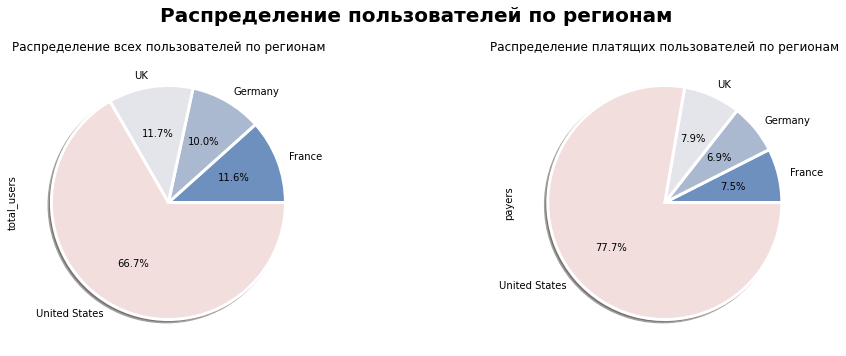

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


plt.subplot(1, 2, 1)
region_rate['total_users'].plot(kind='pie', figsize=(15,5),autopct='%1.1f%%', colors = sns.color_palette('vlag'), 
                           legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
                          )
plt.title('Распределение всех пользователей по регионам')
plt.subplot(1, 2, 2)
region_rate['payers'].plot(kind='pie', figsize=(15,5),autopct='%1.1f%%', colors = sns.color_palette('vlag'),
                           legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
                          )
plt.title('Распределение платящих пользователей по регионам')

fig.suptitle('Распределение пользователей по регионам', fontsize=20, fontweight='bold');
plt.tight_layout()
region_rate.sort_values(by='payers_rate', ascending = False)

**Вывод по регионам:**
* Наибольший поток пользователей наблюдается из Соедененных штатов (66,7 %). Примерно на одном уровне (в районе 10 - 12%) находятся пользователи из Англии, Германии и Франции;
* Платные действия в основном совершают пользователи из Соедененных штатов (77,7 %). Оставшаяся часть покупок (в районе 7-8% на страну) приходится на пользователи из Англии, Германии и Франции.

#### Распределение пользователей по устройствам

In [30]:
device_rate = profiles.groupby('device').agg({'user_id': 'nunique'})
device_rate = device_rate.rename(columns={'user_id': 'total_users'})
device_rate['payers'] = profiles.query('payer == True').groupby('device').agg({'user_id': 'nunique'})
device_rate['payers_rate'] = device_rate['payers'] / device_rate['total_users']

,total_users,payers,payers_rate
device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


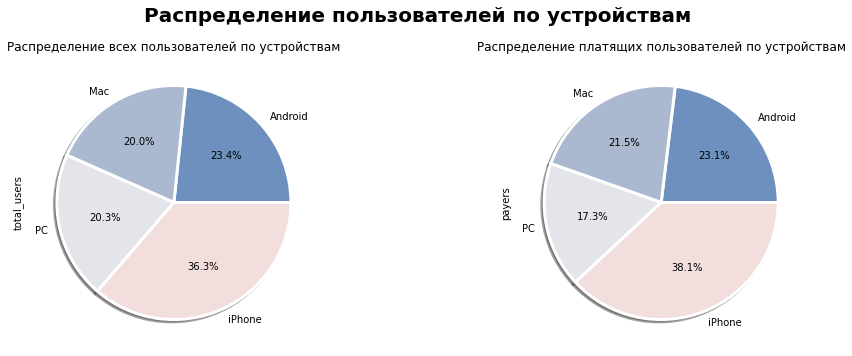

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


plt.subplot(1, 2, 1)
device_rate['total_users'].plot(kind='pie', figsize=(15,5),autopct='%1.1f%%', colors = sns.color_palette('vlag'), 
                           legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
                          )
plt.title('Распределение всех пользователей по устройствам')
plt.subplot(1, 2, 2)
device_rate['payers'].plot(kind='pie', figsize=(15,5),autopct='%1.1f%%', colors = sns.color_palette('vlag'),
                           legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
                          )
plt.title('Распределение платящих пользователей по устройствам')

fig.suptitle('Распределение пользователей по устройствам', fontsize=20, fontweight='bold');
plt.tight_layout()
device_rate.sort_values(by='payers_rate', ascending = False)

**Вывод по устройствам:**
* Приложением чаще всего пользуются на IPhone; 
* Доля PC, MAC и Android примерно одинаковая;
* Сильного различия по ислользованию устройств среди платящих и неплатящих пользователей не наблюдается. 

Дополнительно посмотрим на разбивку по Регионам

In [32]:
device_per_reg = profiles.pivot_table(index='device', columns='region', values='user_id', aggfunc='nunique').reset_index()

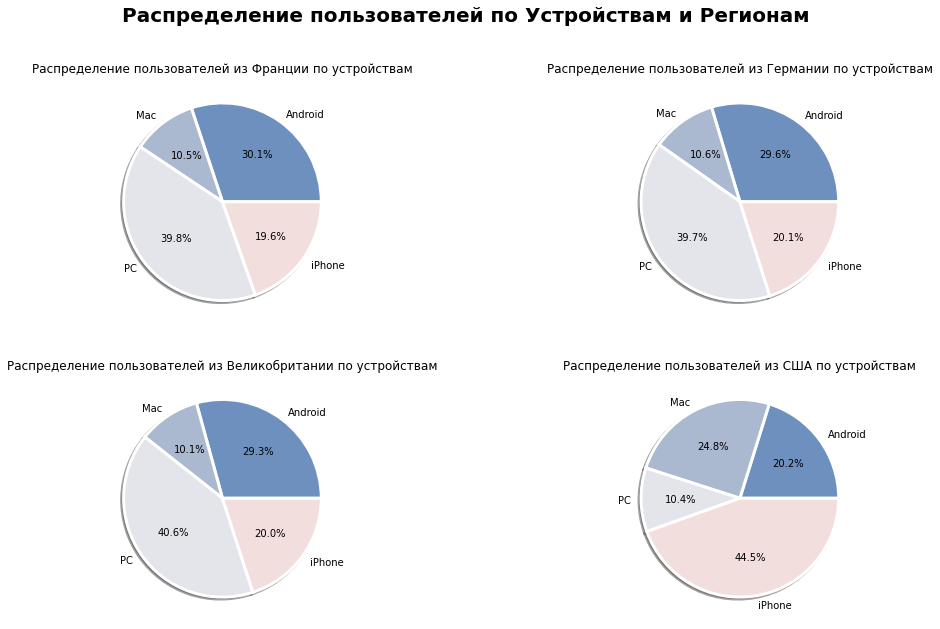

region,device,France,Germany,UK,United States
0,Android,5252,4440,5141,20199
1,Mac,1838,1584,1778,24842
2,PC,6940,5945,7138,10432
3,iPhone,3420,3012,3518,44529


In [33]:
fig, ax = plt.subplots(2, 2, figsize = (17, 10),  squeeze=False)
ax[0][0].pie(device_per_reg['France'], labels = device_per_reg['device'], autopct='%1.1f%%', 
                              colors = sns.color_palette('vlag'),
                              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
            )
ax[0][0].set(title='Распределение пользователей из Франции по устройствам')

ax[0][1].pie(device_per_reg['Germany'], labels = device_per_reg['device'], autopct='%1.1f%%', 
                              colors = sns.color_palette('vlag'),
                              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
            )
ax[0][1].set(title='Распределение пользователей из Германии по устройствам')

ax[1][0].pie(device_per_reg['UK'], labels = device_per_reg['device'], autopct='%1.1f%%', 
                              colors = sns.color_palette('vlag'),
                              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
            )
ax[1][0].set(title='Распределение пользователей из Великобритании по устройствам')

ax[1][1].pie(device_per_reg['United States'], labels = device_per_reg['device'], autopct='%1.1f%%', 
                              colors = sns.color_palette('vlag'),
                              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
            )
ax[1][1].set(title='Распределение пользователей из США по устройствам')

fig.suptitle('Распределение пользователей по Устройствам и Регионам', fontsize=20, fontweight='bold');
plt.show()
device_per_reg

**Вывод по распределению пользоватей по устроиствам и регионам:**
* Европейские пользователи чаще всего впервые заходят в приложение с PC (около 40%), реже с устроиств Android (29 - 30%).
* С продуктов Apple на европейском рынке заходят реже. 20% пользователей использовали iPhone и всего 10-11% Mac.
* Почти половина пользователей США являются владельцами iPhone. Так же в отличие от Европы почти четверть пользуются устроиствами Mac. 
* Реже всего Американцы используют PC, всего 10,4% пользователей 

#### Рекламные источники

- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [34]:
channel_rate = profiles.groupby('channel').agg({'user_id': 'nunique'})
channel_rate = channel_rate.rename(columns={'user_id': 'total_users'})
channel_rate['payers'] = profiles.query('payer == True').groupby('channel').agg({'user_id': 'nunique'})
channel_rate['payers_rate'] = channel_rate['payers'] / channel_rate['total_users']
channel_total = channel_rate.nlargest(5,'total_users')
channel_payer = channel_rate.nlargest(5,'payers')

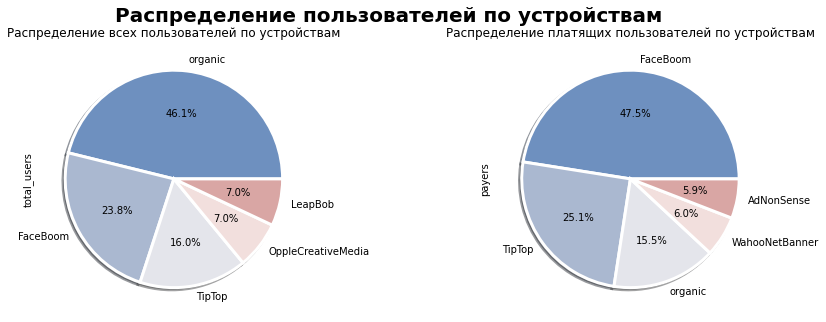

,total_users,payers,payers_rate
channel,,,
FaceBoom,29144,3557,0.122049
AdNonSense,3880,440,0.113402
lambdaMediaAds,2149,225,0.104700
TipTop,19561,1878,0.096007
RocketSuperAds,4448,352,0.079137


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


plt.subplot(1, 2, 1)
channel_total['total_users'].plot(kind='pie', figsize=(15,5),autopct='%1.1f%%', colors = sns.color_palette('vlag'),
                           legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
                                 )
plt.title('Распределение всех пользователей по устройствам')

plt.subplot(1, 2, 2)
channel_payer['payers'].plot(kind='pie', figsize=(15,5),autopct='%1.1f%%', colors = sns.color_palette('vlag'),
                           legend=False, wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, shadow=True
                            )
plt.title('Распределение платящих пользователей по устройствам')

fig.suptitle('Распределение пользователей по устройствам', fontsize=20, fontweight='bold');
plt.show()

channel_rate.sort_values(by='payers_rate', ascending = False).head()

**Вывод по рекламным источникам:**
* В ТОП-5 рекламных источников среди **всех пользователей** попали FaceBoom, TipTop, OppleCreativeMedia, и LeapBob. 
* Среди всех пользователей чаще всего на приложение переходят без рекламных источников (46,1 %). 
* В ТОП-5 рекламных источников среди **платящих пользователей** попали FaceBoom, TipTop, WahooNetBanner, и AdNonSense. 
* Среди платящей аудитории больше всего переходов было совершено через FaceBoom (47,5 %)
* В ТОП-5 рекламных источников, с наивысшей долей платящих на канал привлечения вошли FaceBoom, AdNonSense, lambdaMediaAds, TipTop и RocketSuperAds.

Посмотрим распределение рекламных каналов по регионам 

In [36]:
channel_per_region = (profiles[profiles['payer']==True]
                      .pivot_table(index='channel',columns = 'region',values = 'user_id',aggfunc='count')
                      .reset_index()
                      .query('channel != "organic"')
                     )
channel_per_region.sort_values(by='France', ascending = False)

region,channel,France,Germany,UK,United States
7,WahooNetBanner,152.0,148.0,153.0,NaN
0,AdNonSense,150.0,142.0,148.0,NaN
2,LeapBob,90.0,69.0,103.0,NaN
9,lambdaMediaAds,82.0,67.0,76.0,NaN
4,OppleCreativeMedia,80.0,64.0,89.0,NaN
1,FaceBoom,NaN,NaN,NaN,3557.0
3,MediaTornado,NaN,NaN,NaN,156.0
5,RocketSuperAds,NaN,NaN,NaN,352.0
6,TipTop,NaN,NaN,NaN,1878.0
8,YRabbit,NaN,NaN,NaN,165.0


Среди 10 рекламных каналов 5 работают только на Европейской территории и 5 только на территории США

Пользовательский портрет понятен. Теперь можно разобрать расходы на маркетинг

### Маркетинг


#### Рассход на маркетинг по рекламным источникам 

Посчитаем общую сумму расходов на маркетинг

In [37]:
print('Общая сумма затрат на маркетинг:', costs['costs'].sum())

Общая сумма затрат на маркетинг: 105497.30000000002


Посмотрим как траты распределены по рекламным источникам (сколько денег потратили на каждый источник).

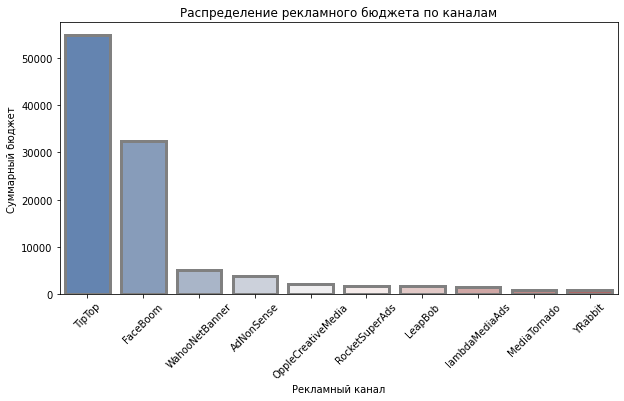

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [38]:
cost_per_channel = costs.groupby('channel').agg('sum').sort_values(by='costs', ascending = False)

plt.figure(figsize=(10,5))
sns.barplot(x=cost_per_channel.index, y=cost_per_channel['costs'], linewidth=3, edgecolor="grey", palette='vlag')
plt.xticks(rotation = 45)
plt.title("Распределение рекламного бюджета по каналам")
plt.xlabel("Рекламный канал")
plt.ylabel("Суммарный бюджет")
plt.show()
cost_per_channel

Львиная доля бюджета (почти 50%) на маркетинг была выделена в TipTop. Вторым по значимости вложений стал FaceBoom (30% бюджета). Стоит отметить что эти два канала показывают рекламу только в США, соответственно почти 80% бюджета оседает на рекламном рынке Америки. 

Посмотри мна распределени бюджета относительно месяца и недели:

In [39]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

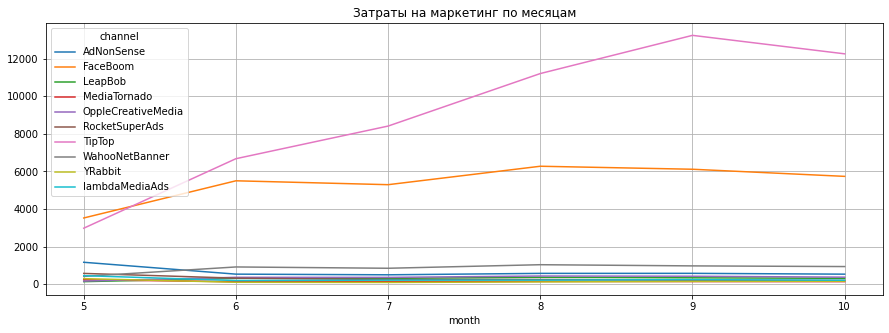

In [40]:
costs.pivot_table(index='month',columns='channel',values='costs',aggfunc='sum').plot(figsize=(15, 5), grid=True)
plt.title('Затраты на маркетинг по месяцам')
plt.show()

**Вывод по месечным затратам:**
* Все каналы, кроме TipTop и FaceBoom "лежат" на графике. 
* Первый месяц затраты на TipTop и FaceBoom находятся на одном уровне. 
* Со второго месяца маркетинговые затраты на TipTop начинают расти и достигают максимальной отметки в сентябре, привысив стартовые показатели в два раза, в то время как затраты на FaceBoom оставались на том же уровне.

Text(0.5, 1.0, 'Затраты на маркетинг по неделям')

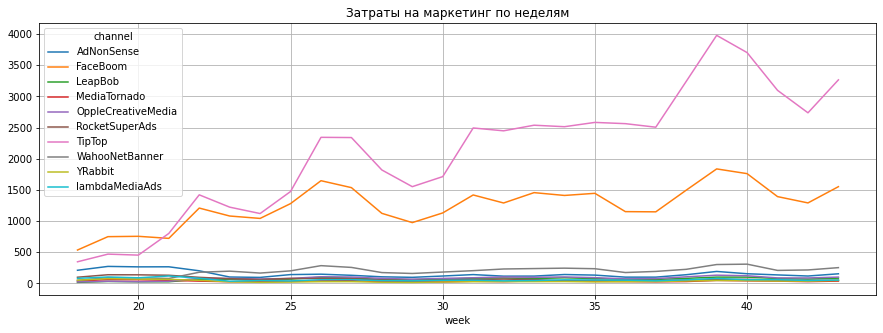

In [41]:
costs.pivot_table(index='week',columns='channel',values='costs',aggfunc='sum').plot(figsize=(15, 5), grid=True)
plt.title('Затраты на маркетинг по неделям')

**Вывод по недельным затратам:**
* Все каналы, кроме TipTop и FaceBoom все так же "лежат" на графике. 
* До 21-й недели затраты на TipTop были ниже чем на FaceBoom. 
* Вложения на TipTop и FaceBoom от недели к неделе идут пропорцианально, достигая пика на 39 неделе и резко снижаясь к 42.
* В конце изучаемого периода траты на TipTop и FaceBoom начиная с 42 недели снова начинают расти

#### Средняя стоимость привлечения одного пользователя (CAC)

In [42]:
cac_channel = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac_channel = cac_channel.sort_values(by='cac', ascending = False)
cac_channel

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


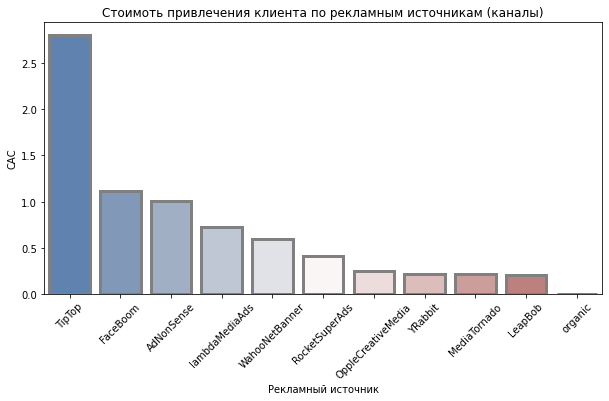

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x=cac_channel.index, y=cac_channel['cac'], linewidth=3, edgecolor="grey", palette='vlag')
plt.xticks(rotation = 45)
plt.title("Стоимоть привлечения клиента по рекламным источникам (каналы)")
plt.xlabel("Рекламный источник")
plt.ylabel("САС")
plt.show()
cac_channel


**Вывод по CAC (каналы):**
* Пользователи из TipTop обходятся дороже всех; 
* Привлечение пользователей из FaceBoom и AdNonSense стоят в районе 1 у.е.. **Стоит учитывать что FaceBoom приносит почти половину платящих пользователей**;
* Остальные источники не прывышают стоимость 1 у.е..

In [44]:
cac_region = (
    profiles.groupby('region')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac_region = cac_region.sort_values(by='cac', ascending = False)

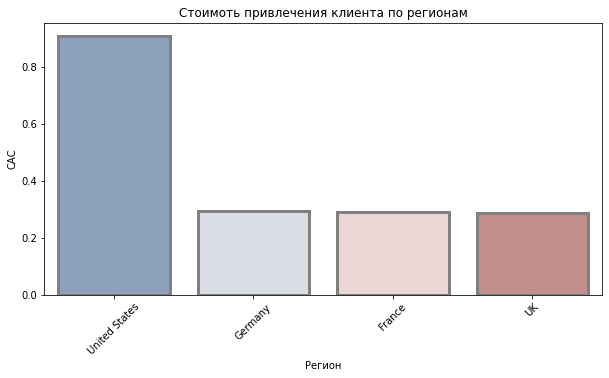

,cac
region,
United States,0.909268
Germany,0.295322
France,0.290887
UK,0.288393


In [45]:
plt.figure(figsize=(10,5))
sns.barplot(x=cac_region.index, y=cac_region['cac'], linewidth=3, edgecolor="grey", palette='vlag')
plt.xticks(rotation = 45)
plt.title("Стоимоть привлечения клиента по регионам")
plt.xlabel("Регион")
plt.ylabel("САС")
plt.show()
cac_region

**Вывод по CAC (регион):**
* Пользователи из США самые дорогие в привлечении; 
* Стоимость привлечения пользователей из Германии, Франции и Великобритании находится на одном уровне;
* Европейские пользователи в три раза выгоднее Американских; 

In [46]:
cac_month = (
    profiles.groupby('month')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac_month = cac_month.sort_values(by='cac', ascending = False)

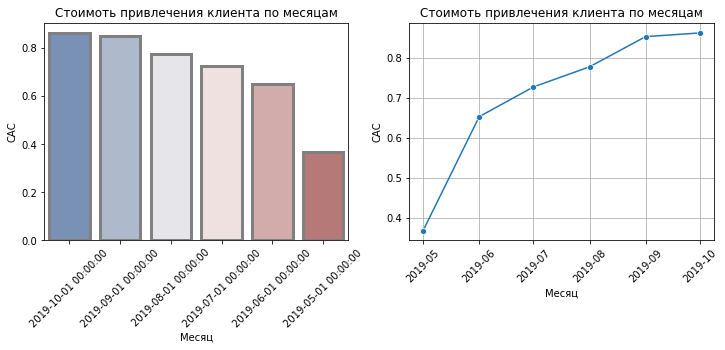

,cac
month,
2019-10-01,0.861699
2019-09-01,0.852408
2019-08-01,0.777021
2019-07-01,0.726878
2019-06-01,0.652599
2019-05-01,0.368064


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.barplot(x=cac_month.index, y=cac_month['cac'], linewidth=3, edgecolor="grey", palette='vlag')
plt.xticks(rotation = 45)
plt.title("Стоимоть привлечения клиента по месяцам")
plt.xlabel("Месяц")
plt.ylabel("САС")

plt.subplot(1, 2, 2)
sns.lineplot(x=cac_month.index, y=cac_month['cac'], marker = "o")
plt.xticks(rotation = 45)
plt.title("Стоимоть привлечения клиента по месяцам")
plt.xlabel("Месяц")
plt.ylabel("САС")
plt.grid()
plt.show()
cac_month

**Вывод по CAC (по месяцам):**
* В начале исследовательского периода стоимость пользователя была всего 0,37 у.е. Самый низкий САС за весь периода; 
* После резкого увеличения почти на 0,2 пункта в июне стоимоть пользователя стабильно увеличивается на 0,05 - 0,07 у.е. на протяжении трех месяцев;
* На конец периода стоимость привлечения достикла 0,86 у.е. став самым дорогим месяцем; 

### Оцените окупаемость рекламы


Проверим окупаются ли привлеченные пользователи за 2 недели. Поскольку мы имеем дело с бюджетом на рекламу, органических пользователей следует исключить - они нам ничего не стоили.  

In [48]:
observation_date = datetime(2019, 11, 1).date()  
analysis_horizon = 14

payed_cust = profiles.query('channel != "organic"')

#### Графики LTV и ROI, графики динамики LTV, CAC и ROI

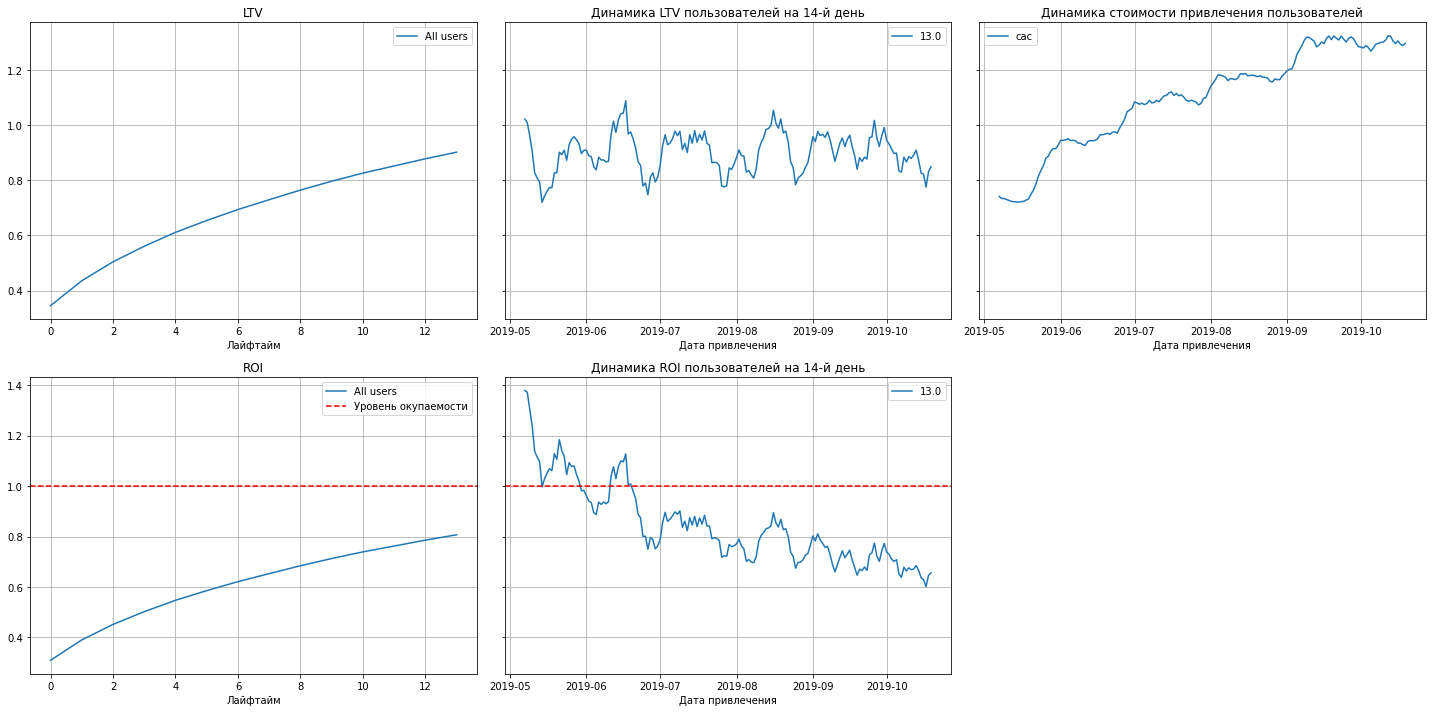

In [49]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(payed_cust, orders, observation_date, analysis_horizon)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

**Вывод по окупаемости рекламы:**
* LTV построен верно. График плавно растет, не опускается, в пике доходит до показателя 0,9
* В динамике LTV присутствуют резкие спады и возвышения, но в целом держится в одном и том же диапазоне. 
* Стоимость привлечения пользователя постоянно растет и за 5 месяцев выросла примерно в два раза. 
* Пользователи не окупаются
* Привлечение пользователей перестало окупаться в середине Июня, и с каждым последующим месяцем становится все дальше от зоны окупаемости.

#### Конверсия и удержание пользователей

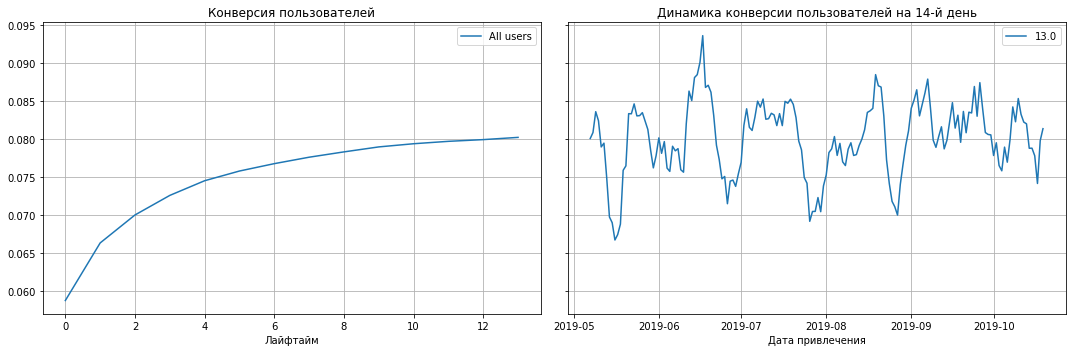

In [50]:
conversion_raw, conversion, conversion_history = get_conversion(
    payed_cust, visits, observation_date, analysis_horizon)

plot_conversion(conversion, conversion_history, analysis_horizon)

Коверсия плавно поднимается до 10го дня и после остается в районе 0,08. Динамика конверсии показывает хороший приход платильщиков в середине июня, стабильный с начала июля и до его середины. Самым слабым периодом оказался середина мая. 

Рассмотрим конверсию по регионам и устройствам. 

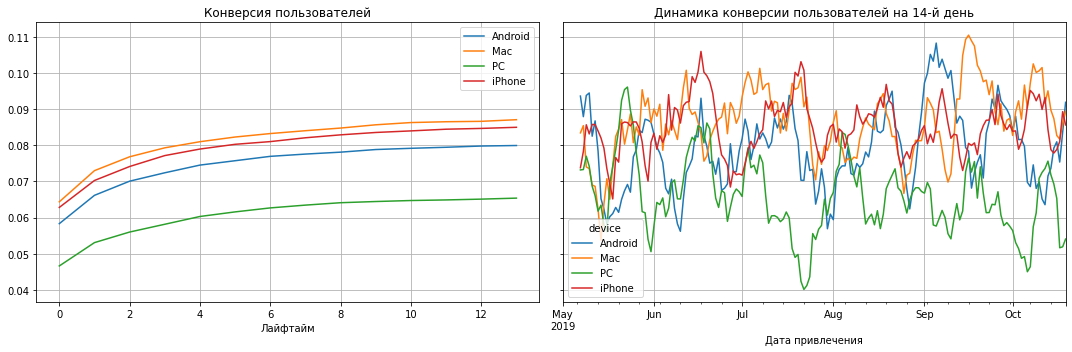

In [51]:
conversion_raw, conversion, conversion_history = get_conversion(
    payed_cust, visits, observation_date, analysis_horizon, dimensions=['device'])

plot_conversion(conversion, conversion_history, analysis_horizon)

Лучше всего конверсию показывают Mac и iPhone, которыми пользуюся в США. Самая низкая конверсия у пользователей PC.

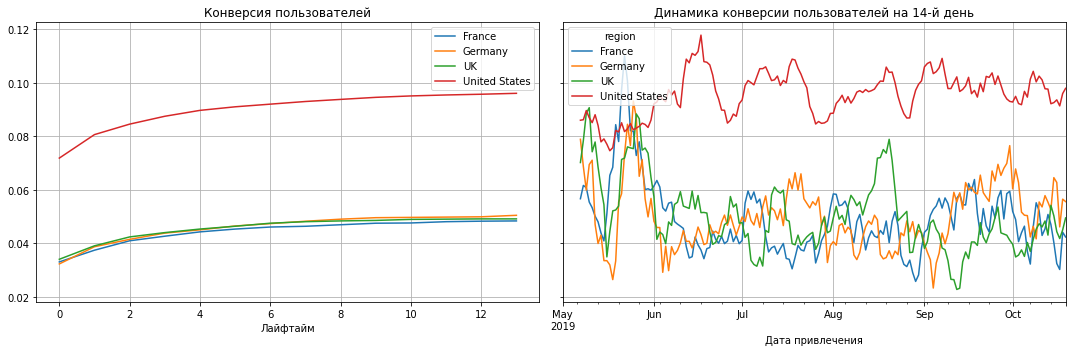

In [52]:
conversion_raw, conversion, conversion_history = get_conversion(
    payed_cust, visits, observation_date, analysis_horizon, dimensions=['region'])

plot_conversion(conversion, conversion_history, analysis_horizon)

Ожидаемо конверсия пользователей из США Сильно превосходит Европейских. Динамика же показывает что на старте изучаемого периода позьзователи Франции, Германии и Великобритании по конверсии были на уровне США, и даже превосходили их показатели. После июня Европа больше не показывала высокой конверсии, за исключением вспышки в середине августа на территории Великобритании.

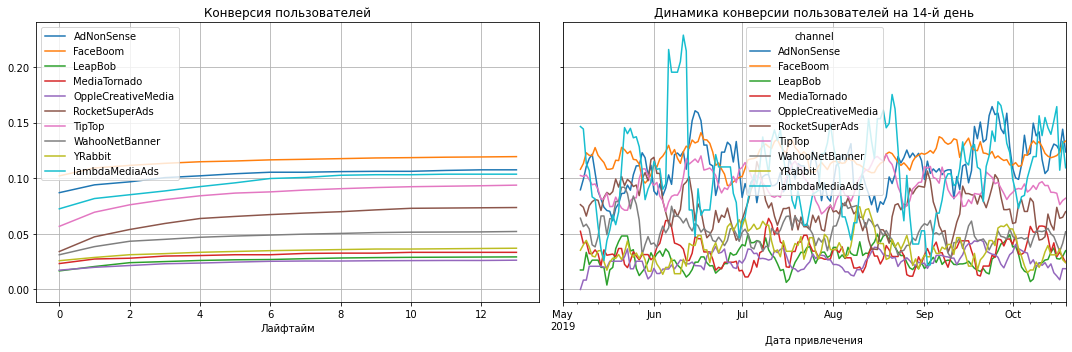

In [53]:
conversion_raw, conversion, conversion_history = get_conversion(
    payed_cust, visits, observation_date, analysis_horizon, dimensions=['channel'])

plot_conversion(conversion, conversion_history, analysis_horizon)

Лидером по конверсии стал FaceBoom. В тройку так же попали AdNonSense и LambdaMediaAds. В динамике хорошую, но не постоянную конверсию показывает LambdaMediaAds (за отличительными пиковыми показателями, следуют такие же отличительные спады). Хуже всего конверсия идет в OppleCreativeMedia

**Вывод по конверсии:**
* США показывает лучшую конверсию среди изучаемых регионов. 
* Конверсия Европейских стран резко поднимается в конце мая и после стабильно низка. 
* Пользователи Mac и iPhone лидируют по конверсии. Скорей всего это вызвано большим кол-вом пользователей из США. 
* Среди каналов лучшую конверсию демонтрирует FaceBoom

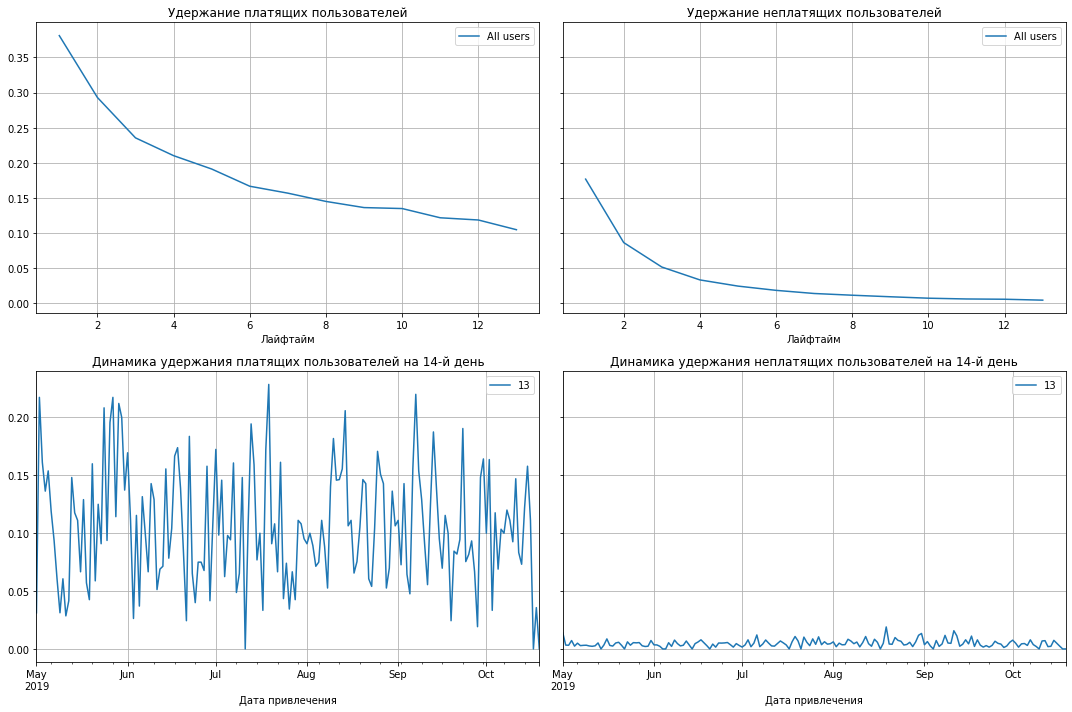

In [54]:
retention_raw, retention, retention_history = get_retention(payed_cust, visits, observation_date, analysis_horizon)

plot_retention(retention, retention_history, analysis_horizon)

Платящие пользователи остаются в приложении ожидаемо дольше. Неплатящие теряют интерес на восьмой день. Динамику платящих достаточно сильно штормит, достигая порой нулевые значения. 

Посмотрим удержание по устройствам и регонам 

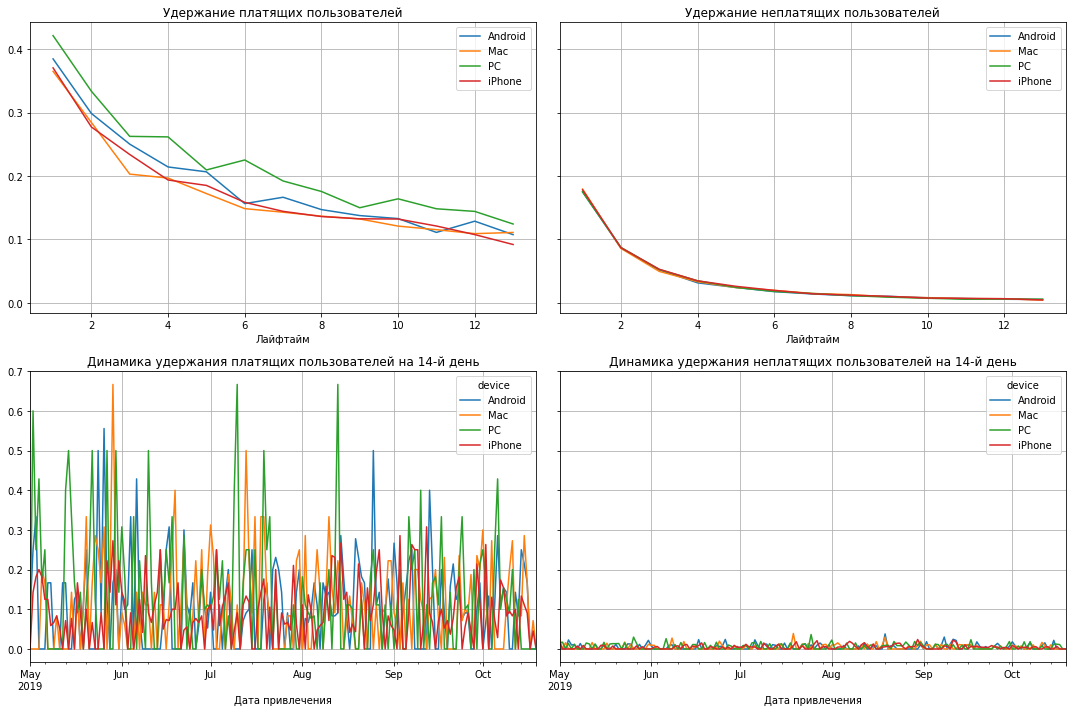

In [55]:
retention_raw, retention, retention_history = get_retention(
    payed_cust, visits, observation_date, analysis_horizon, dimensions=['device'])

plot_retention(retention, retention_history, analysis_horizon)

PC и Android, которые плохо конвертировались, показывают достаточно хорошие показатели удержания платных пользователей. В динамике пользователи iPhone не превышают показателя в 0,3, в то время как пиковые значения PC подбираются к 0,7

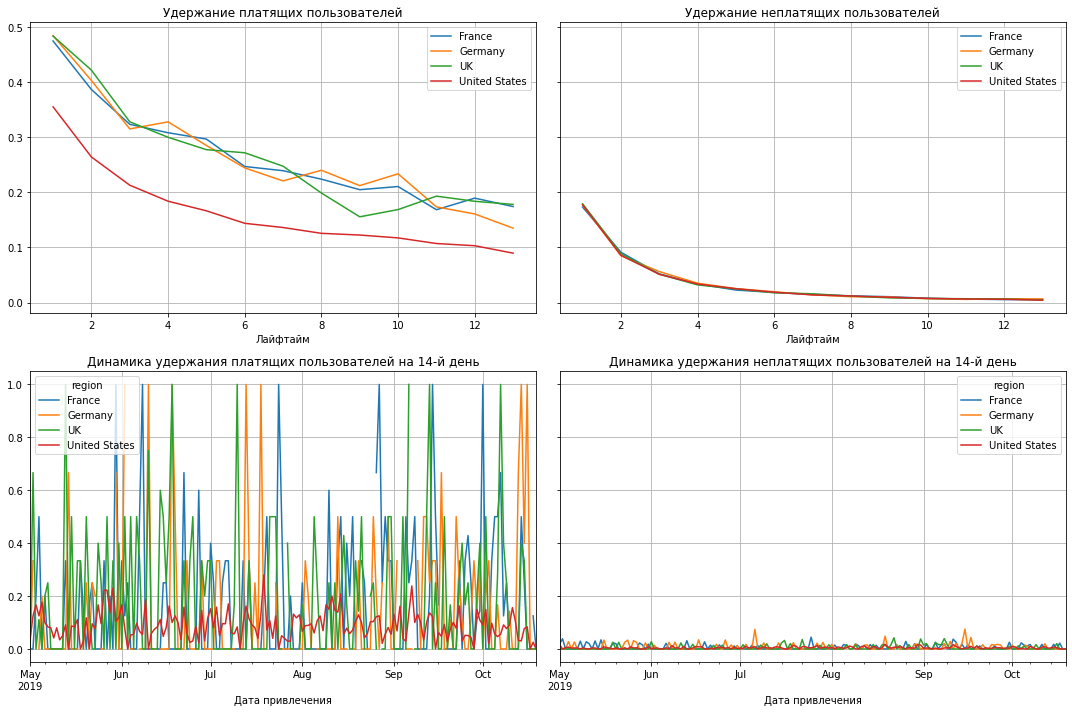

In [56]:
retention_raw, retention, retention_history = get_retention(
    payed_cust, visits, observation_date, analysis_horizon, dimensions=['region'])

plot_retention(retention, retention_history, analysis_horizon)

Платящие Европейцы удерживаются гораздо лучше чем американцы. В динамике удержание на 14й день Франции, Германии и Великобритании порой достигает единицы, тогда как в США пиковое значение находится в районе 0,3

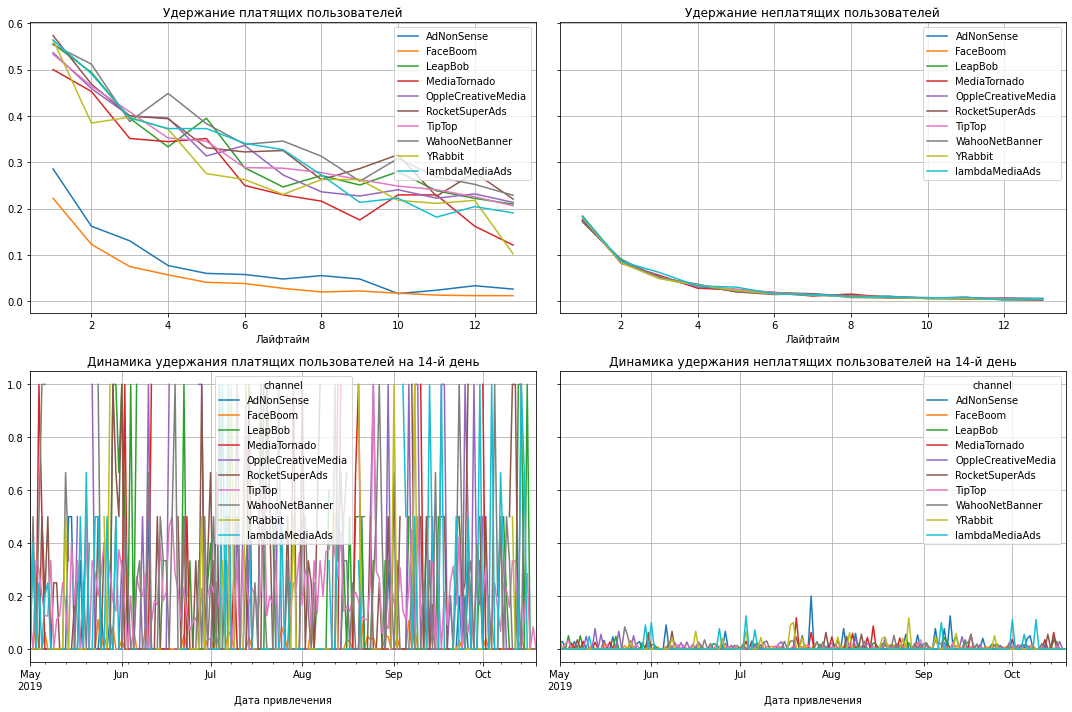

In [57]:
retention_raw, retention, retention_history = get_retention(
    payed_cust, visits, observation_date, analysis_horizon, dimensions=['channel'])

plot_retention(retention, retention_history, analysis_horizon)

Лидеры по конверсии FaceBoom и AdNonSense оказались аутсайдерами по удержанию.  Остальные 8 каналов примерно в одном и том же диапазоне значений.

**Вывод по удержанию:**
* Европейцы проводят в приложении большее кол-во дней чем пользователи из Америки. 
* Пользователи PC (который в приоритете у Европейцев), так же показывают хорошее удержание. 
* Несмотря на хорошую конверсию iPhone, показатели удержания находится достаточно низко. 
* Среди каналов FaceBoom и AdNonSense справляются с удержанием заметно хуже чем остальные. 

#### Графики LTV и ROI, графики динамики LTV, CAC и ROI по устроиствам

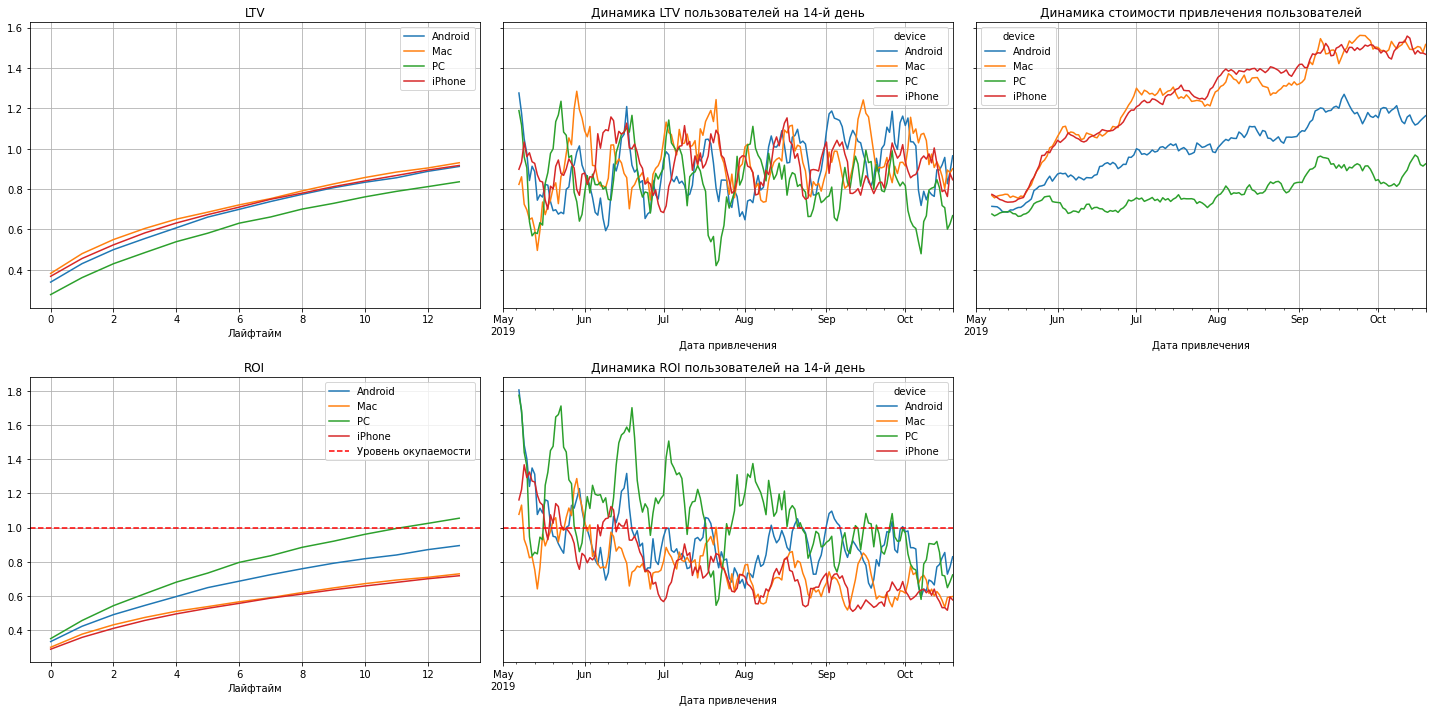

In [58]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    payed_cust, orders, observation_date, analysis_horizon, dimensions = ['device']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

**Вывод по окупаемости рекламы по устроиствам:**
* Самыми дорогими являются пользователи Mac и iPhone, самыми дешевыми - пользователи PC 
* Окупаемости достигают только пользователи PC. 
* Начиная с августа в ROI наблюдается снижение по всем устроиствам. 

#### Графики LTV и ROI, графики динамики LTV, CAC и ROI по странам

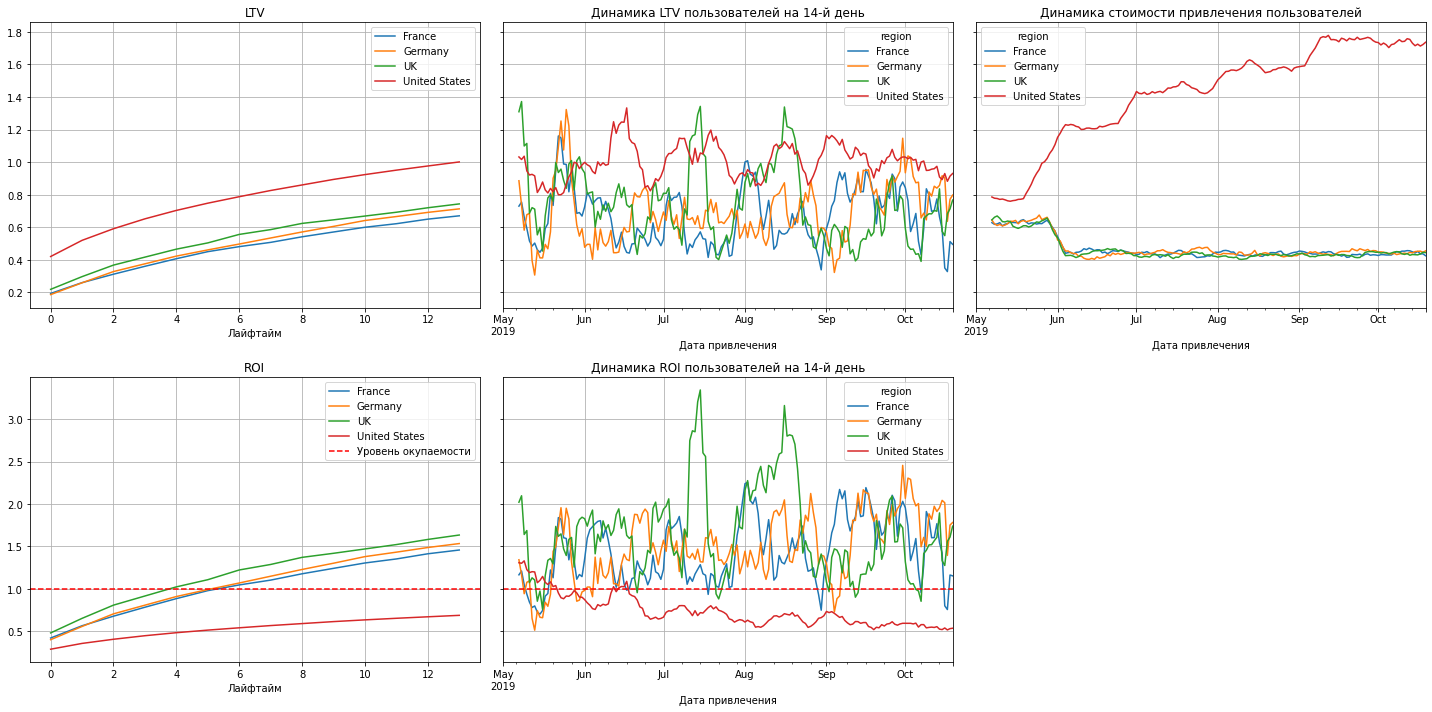

In [59]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    payed_cust, orders, observation_date, analysis_horizon, dimensions = ['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

**Вывод по окупаемости рекламы по странам:**
* Привлечение пользователей из США обходится неимоверно дорого, в сравнении с Европейскими пользователями. 
* Великобритания, Германия и Франция окупаются на ранних этапах. США точки окупаемости не достигает 
* Динамика ROI для европейских стран стабильно высокая. На положительной динамике особенно выделяются пользователя из Великобритании с пиковыми значениями в середине Июля и середине Сентября 

#### Графики LTV и ROI, графики динамики LTV, CAC и ROI по рекламным каналам (Совокупно)

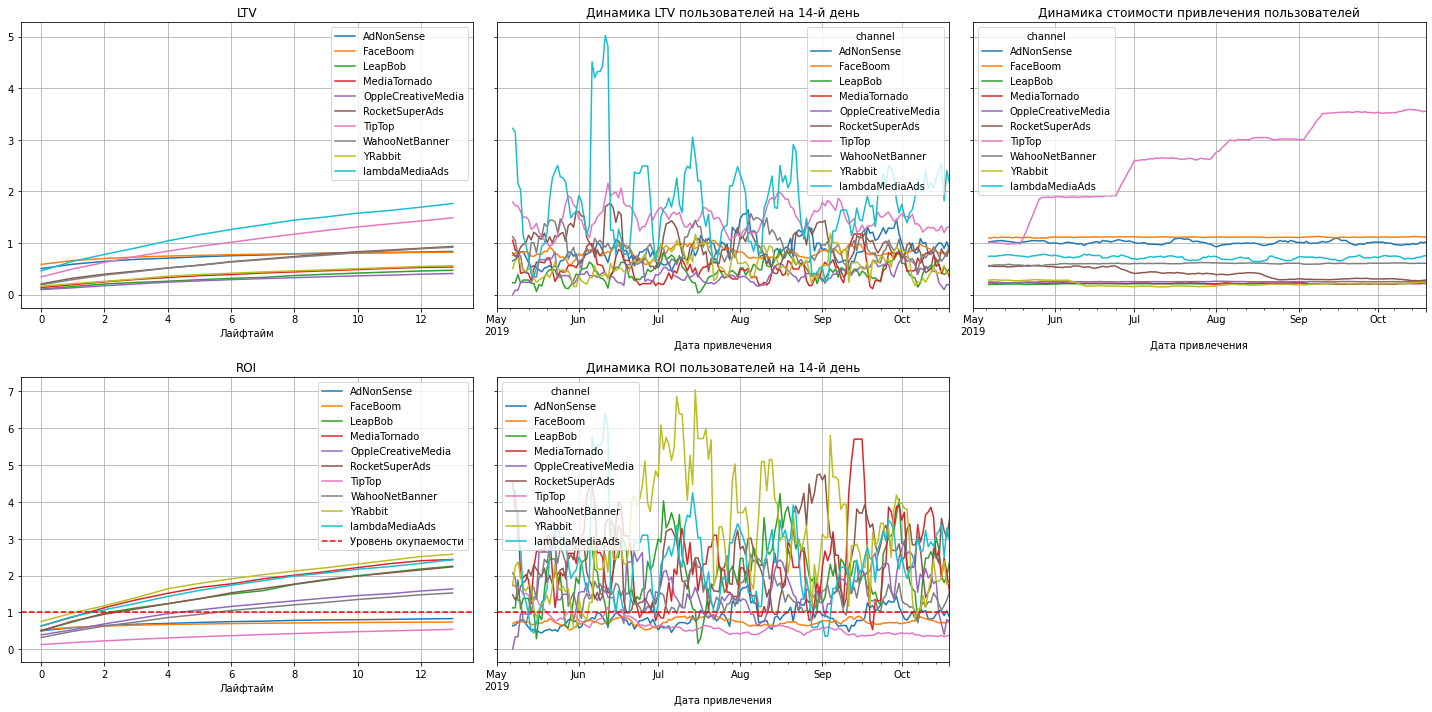

In [60]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    payed_cust, orders, observation_date, analysis_horizon, dimensions = ['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

**Вывод по окупаемости рекламы по каналам (Совокупно):**
* В динамике LTV сильно выделяется LambdaMediaAds. Остальные каналы стабильны 
* Стоимость привлечения пользователей из TipTop растет с каждым месяцем и превосходит остальные источники в два раза
* Окупаемости не достигают только FaceBoom, AdNonSense и TipTop. Остальные каналы окупаются в промежутке от 2го по 4й день.
* В динамике ROI с пиковыми значениями выделяются YRabbit, LambdaMediaAds и MediaTornado. Эти же рекламные источники находятся в топ-3 по окупаемости в целом. 

#### Графики LTV и ROI, графики динамики LTV, CAC и ROI по рекламным каналам (Америка)

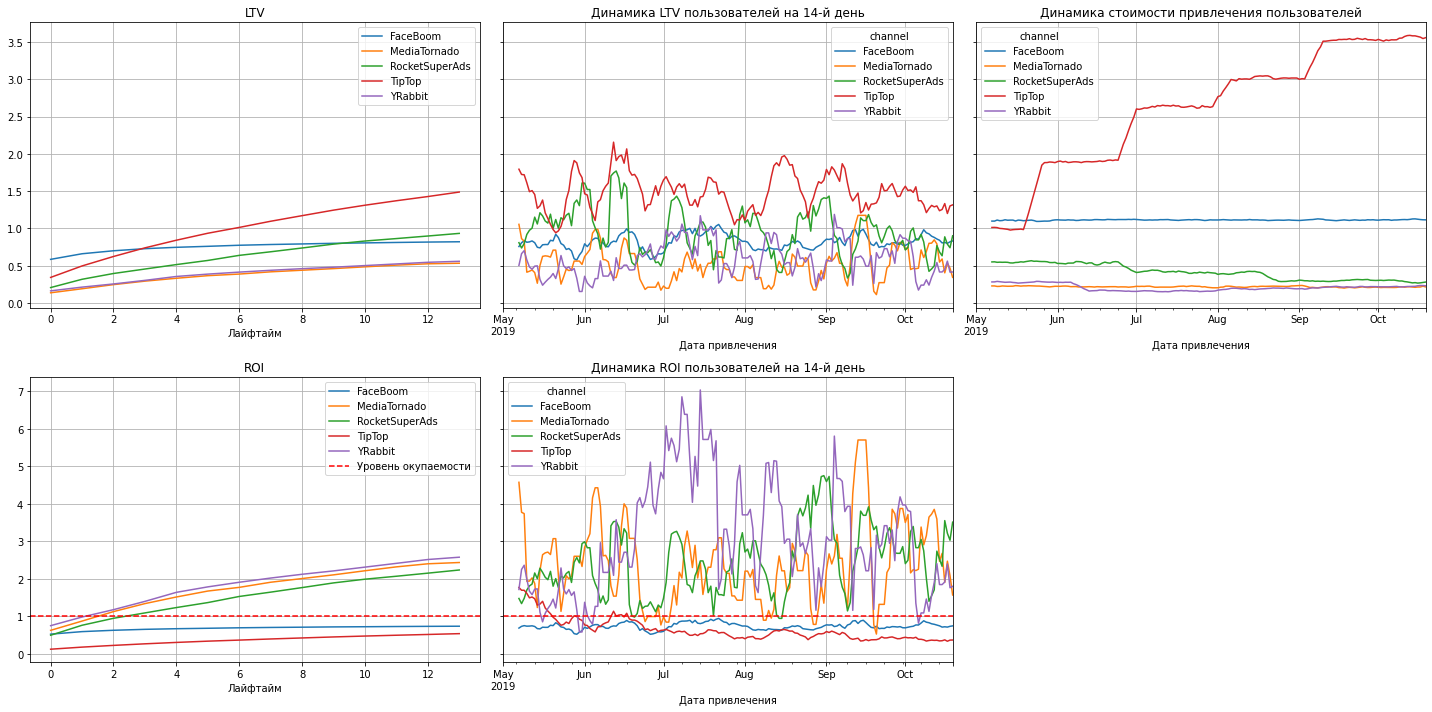

In [61]:
us_channel = payed_cust.loc[payed_cust['region'] == 'United States']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    us_channel, orders, observation_date, analysis_horizon, dimensions = ['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

**Вывод по окупаемости рекламы по каналам (Совокупно):**
* Стоимость TipTop выделяется даже на фоне сокращенной Американской выборки, с ежемесечным ростом показателей
* FaceBoom и TipTop не окупаются
* YRabbit, MediaTornado и RocketSuperAds показывают отличный ROI как в окупаемости, так и в динамике. 

#### Графики LTV и ROI, графики динамики LTV, CAC и ROI по рекламным каналам (Европа)

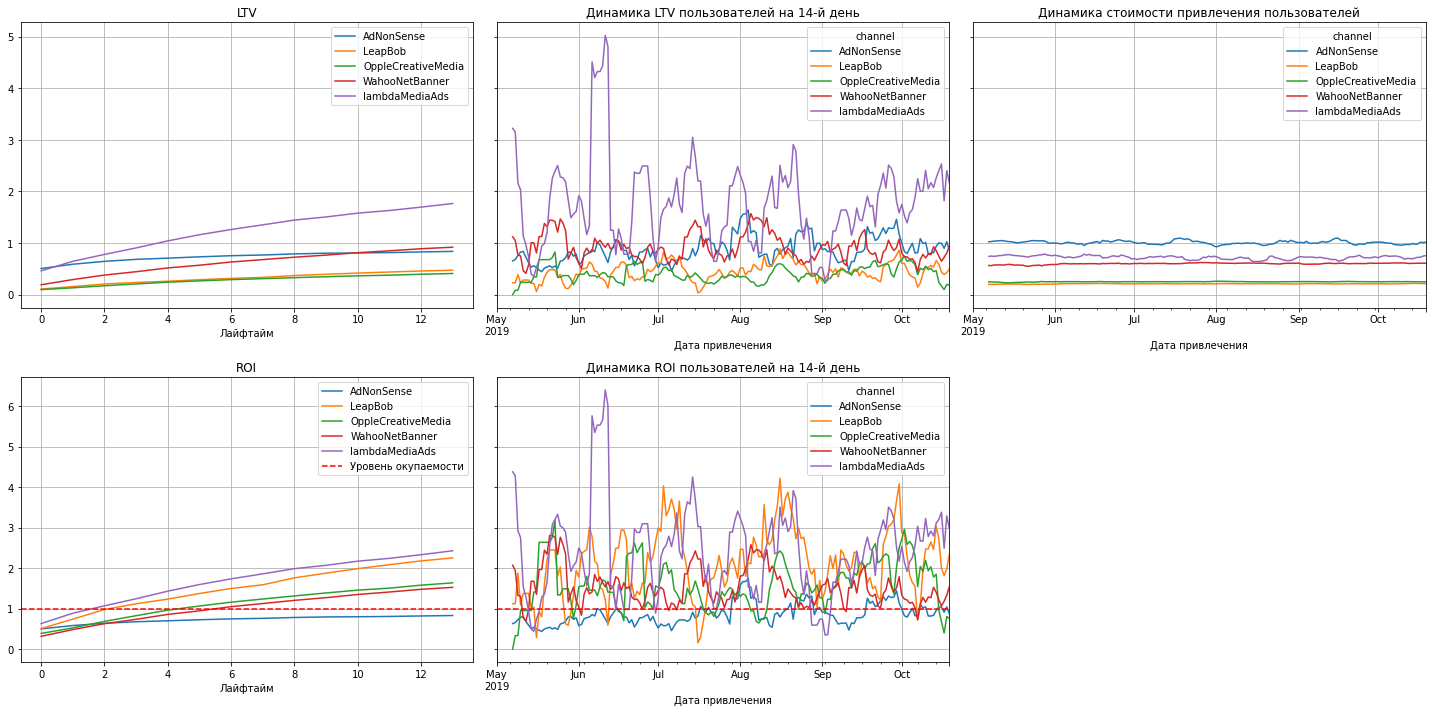

In [62]:
us_channel = payed_cust.loc[payed_cust['region'] != 'United States']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    us_channel, orders, observation_date, analysis_horizon, dimensions = ['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, analysis_horizon, window=7)

**Вывод по окупаемости рекламы по каналам (Европа):**
* В LTV сильно выделяется LambdaMediaAds. Это заметно как в прогрессии, так и в динамике 
* Стоимость привлечения на всех каналах без колебаний
* Среди европейских каналов только AdNonSense не доходит до порога окупаемости
* В динамике ROI так же выделяется LambdaMediaAds на начале исследуемого периода, но ближе к июлю все окупаемые каналы находятся примерно в одном и том же диапазоне

### Общий вывод

В нашем распоряжении были данные о пользователях развлекательного приложения Procrastinate Pro+, привлечённых с 1 мая по 27 октября 2019 года. Задача - разобраться в причинах убытков и помочь компании в выборе рекламной стратегии и рекламных каналах.

Для этого данные были приведны в "рабочее" состоянии, проверены на дубликаты и пропуски. Помимо этого перед началом исследования были заданы функции, которые составили портрет пользователей, конверсию и удержание, а так же упростили оценку окупаемости рекламного бюджета по источникам, странам и каналам, и помогли наглядно визуализируют полученные данные.

Из портрета пользователей было выяснено следующее:

* Наибольший поток пользователей наблюдается из Соедененных штатов (66,7 %). Примерно на одном уровне (в районе 10 - 12%) находятся пользователи из Англии, Германии и Франции;
* Платные действия в основном совершают пользователи из Соедененных штатов (77,7 %). Оставшаяся часть покупок (в районе 7-8% на страну) приходится на пользователи из Англии, Германии и Франции.
* Приложением чаще всего пользуются на IPhone; 
* Сильного различия по ислользованию устройств среди платящих и неплатящих пользователей не наблюдается.
* Европейские пользователи чаще всего впервые заходят в приложение с PC (около 40%), реже с устроиств Android (29 - 30%).
* Почти половина пользователей США являются владельцами iPhone. 

Маркетинг в исследлуемый период задействовал 10 рекламных каналов. Из них 5 работают только на Европейской территории и 5 только на территории США. Всего на маркетинг было потрачено 105 497 у.е.

Львиная доля бюджета (почти 50%) на маркетинг была выделена в TipTop. Вторым по значимости вложений стал FaceBoom (30% бюджета). Стоит отметить что эти два канала показывают рекламу только в США, соответственно почти 80% бюджета оседает на рекламном рынке Америки.

При рассмотрении стоимости привлечения пользователей в разрезе по месяцам заметно сильный рост цены на одного пользователя. На старте периода средний пользователь стоил 0,37 у.е., на конец перода стоимость возрасла до 0,86 у.е.

<font color='green'> Из плюсов: </font> 
* США показывает лучшую конверсию среди изучаемых регионов. 
* Пользователи Mac и iPhone лидируют по конверсии. Скорей всего это вызвано большим кол-вом пользователей из США.
* Европейцы проводят в приложении большее кол-во дней чем пользователи из Америки. 
* Пользователи PC (который в приоритете у Европейцев) показывают хорошее удержание. 
* Окупаемости достигают только пользователи PC. Они же являются самыми дешевыми по привлечению
* Великобритания, Германия и Франция окупаются на ранних этапах. 
* Динамика ROI для европейских стран стабильно высокая. На положительной динамике особенно выделяются пользователя из Великобритании с пиковыми значениями в середине Июля и середине Сентября 
* В динамике ROI с пиковыми значениями выделяются YRabbit, LambdaMediaAds и MediaTornado. Эти же рекламные источники находятся в топ-3 по окупаемости в целом. 

<font color='red'>Из минусов:</font>  
* Конверсия Европейских стран резко поднимается в конце мая и после стабильно низка. 
* Несмотря на хорошую конверсию iPhone, показатели удержания находится достаточно низко.
* Самыми дорогими по привлечению являются пользователи Mac и iPhone 
* Пользователи Mac, iPhone и Android не окупаются.
* Привлечение пользователей из США обходится неимоверно дорого, в сравнении с Европейскими пользователями. 
* США точки окупаемости не достигает 
* Стоимость привлечения пользователей из TipTop растет с каждым месяцем и превосходит остальные источники в два раза


Очевидно, что причина убытков - завышенные ожидания от американского рынка в целом и от TipTop в частности. Несмотря на хорошую конверсию и долю рынка прибыль это направления маркетинга не показывает. С другой стороны на небольших вложениях европейский рынок показывает не только более высокую лояльность, но и быструю окупаемость. 

<font color='blue'>В качестве рекомендаций, стоит:</font>  
* Отказаться от размещения рекламы в TipTop. 
* Освободившийся бюджет перенести на рекламу в европейских каналах. Среди них лучшую окупаемость показывает LambdaMediaAds
* Увеличить бюджет YRabbit для поддержания динамики рынка США  
* Несмотря на то, что FaceBoom не окупается он все еще приносит большой поток потенциальных пользователь и платящих клиентов не сжирая бюджет на рекламу. Возможно отсутствие продаж при переходе с этого источника связано не с самим каналом, а с устройствами, с которых совершается переход.

Благодарю за внимание!